# Coding Task: Bayesian vs OLS Regression
**Objective:** Compare overfitting resistance and uncertainty quantification between Bayesian and OLS regression with polynomial setting from the theoretical task.

## Setting

We fit a degree-$d$ polynomial basis $$\phi(x)=[1, x, x^2, \ldots, x^d]^\top.$$ Now suppose we have $n$ samples $\{(x_i, y_i): i =1, \dots, n\}$. 
Let $X$ be the predictor matrix with $i$-th row being $\phi(x_i)^\top$ and $y$ is vector of all the response.

## 1. Data Generation

- $n $: number of data points
- $d $: polynomial degree
- $n$ scalar values $x_i$ are generated between $0$ and $1$
- True function $f(x) = \sin(2\pi x)$
- Noise variance $\sigma = 0.3$
- $X$ matrix is constructed as stated above

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Generate data
np.random.seed(0)
n, d = 30, 20
x_train = np.linspace(0, 1, n)
y_true = np.sin(2 * np.pi * x_train)
y_train = y_true + 0.3 * np.random.randn(n)

# Polynomial features
poly = PolynomialFeatures(d, include_bias=True)
X_train = poly.fit_transform(x_train[:, None])

## 2. OLS 

Obtain OLS solution and construct 95% confidence interval (CI):

- **OLS Estimator**: $$\hat{\beta}_{OLS} = (X^\top X)^{-1}X^\top y$$
  
- **OLS 95% confidence interval**: $$\hat{y} \pm 1.96\cdot  \sigma \cdot \sqrt{\phi(x_*)^\top (X^\top X)^{-1}\phi(x_*)},$$
     where, $\sigma^2$ is the variance of the noise.



In [15]:
# OLS fit
ols = LinearRegression(fit_intercept=False).fit(X_train, y_train)
sigma2 = np.mean((y_train - ols.predict(X_train)) ** 2)

# Confidence intervals
x_test = np.linspace(0, 1, 200)
Poly_test = poly.transform(x_test[:, None])
X_train_inv = np.linalg.inv(X_train.T @ X_train)
se = np.sqrt(sigma2 * np.sum(Poly_test @ X_train_inv * Poly_test, axis=1))
ci_up = Poly_test @ ols.coef_ + 1.96 * se
ci_lo = Poly_test @ ols.coef_ - 1.96 * se

## 2. Bayesian Regression

- **Prior**: Gaussian prior with mean 0 and variance $\tau^2$

- **Bayesian Posterior**:
    $$
    p(\beta\,\mid X, y) = \mathcal{N}\left(\beta \,|\,\mu_{post}, \Sigma_{post}\right), \quad
    \Sigma_{post}^{-1} = \frac{1}{\sigma^2}X^\top X + \frac{1}{\tau^2} I, \quad
    \mu_{post} = \Sigma_{post}\frac{1}{\sigma^2}X^\top y.
    $$

  
- **Bayesian 95% credible interval:** $$\phi(x_*)^T\mu_{post} \pm 1.96 \cdot \sqrt{\phi(x_*)^T\Sigma_{post}\phi(x_*) + \sigma^2},$$
     here, $\phi(x_*)^T\mu_{post}$ is the Bayesian posterior prediction.


In [16]:
# Closed-form Bayesian solution
tau2 = 1.0  # Prior variance
A = X_train.T @ X_train / sigma2 + np.eye(d+1) / tau2
Sigma_post = np.linalg.inv(A)
mu_post = Sigma_post @ (X_train.T @ y_train) / sigma2

# Credible intervals
post_var = np.sum(Poly_test @ Sigma_post * Poly_test, axis=1) + sigma2
cb_up = Poly_test @ mu_post + 1.96 * np.sqrt(post_var)
cb_lo = Poly_test @ mu_post - 1.96 * np.sqrt(post_var)

## 3. Visualization & Comparison

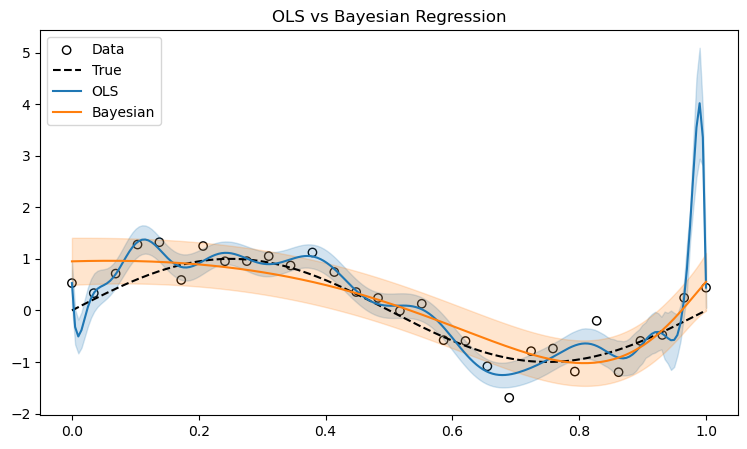

In [17]:
plt.figure(figsize=(9, 5))
plt.scatter(x_train, y_train, facecolors='none', edgecolors='k', label='Data')
plt.plot(x_test, np.sin(2*np.pi*x_test), 'k--', label='True')

# OLS
plt.plot(x_test, Poly_test @ ols.coef_, 'C0-', label='OLS')
plt.fill_between(x_test, ci_lo, ci_up, color='C0', alpha=0.2)

# Bayesian
plt.plot(x_test, Poly_test @ mu_post, 'C1-', label='Bayesian')
plt.fill_between(x_test, cb_lo, cb_up, color='C1', alpha=0.2)

plt.legend()
plt.title('OLS vs Bayesian Regression')
plt.show()

## Exercises & Discussion
1. **Model Complexity**: Vary $d$ (obs: OLS oscillates wildly for large $d$ while Bayesian remains smooth)
2. **Prior Impact**: Try $\tau^2 \in \{0.01, 1, 100\}$ 
